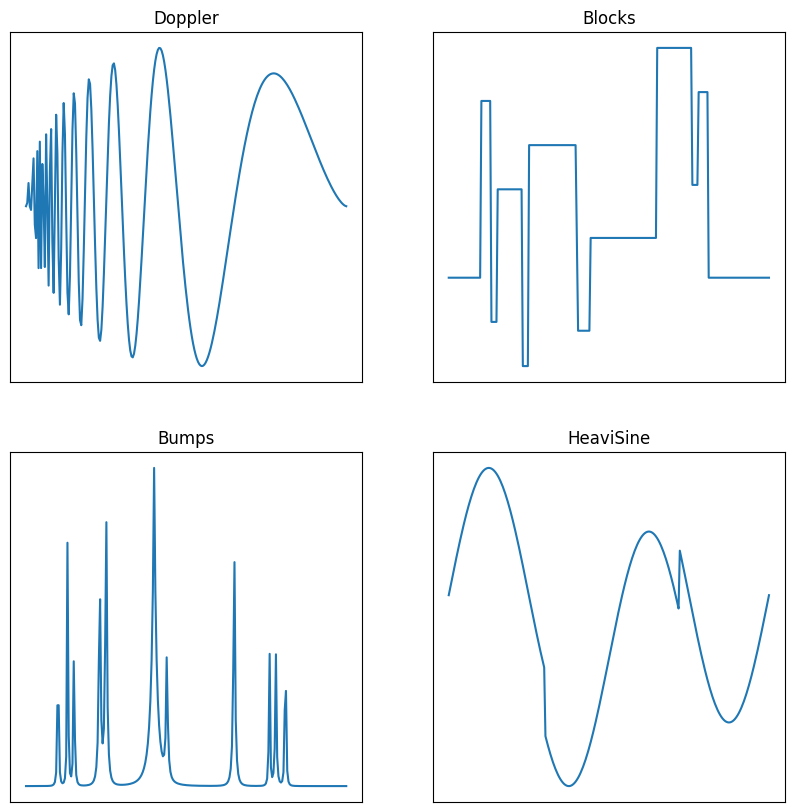

In [181]:
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)
     

x = np.linspace(0,1,2**8)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)     


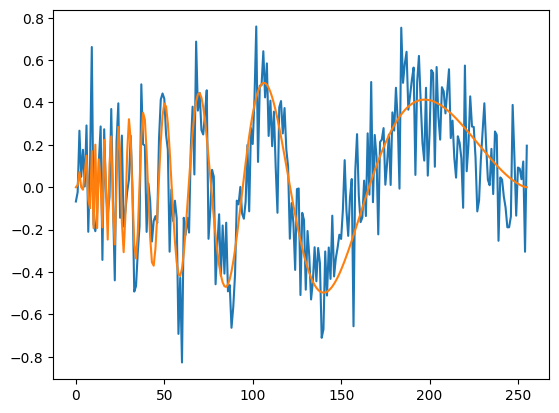

In [182]:

# Generate a sample signal
 
signal = doppler (x) + np.random.normal(0, 0.2,x.shape)
plt.plot(signal)
plt.plot(doppler (x))
# Perform wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet )
 

In [183]:
x.shape

(256,)

In [184]:
np.concatenate(coeffs).shape

(256,)

In [185]:
# Prepare graph data
def build_dyadic_wavelet_graph(coeffs):
    """
    Build a dyadic graph from wavelet decomposition coefficients.
    Each node at level n is connected to two nodes at level n+1.
    Add coefficient indices for detailed representation.
    """
    max_length = max(len(c) for c in coeffs)  # Determine max length of coefficient arrays
    node_features = []  # To store node features
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_feature = np.pad(coeffs[0], (0, max_length - len(coeffs[0])), mode='constant')
    node_features.append(root_feature.tolist())
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = coeffs[0][0]  # Use the first coefficient of the root

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(coeffs[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    padded_feature = np.pad([c[coeff_index]],
                                            (0, max_length - 1), mode='constant')
                    node_features.append(padded_feature.tolist())
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = c[coeff_index]  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), node_labels, node_levels, node_coefficients

# Draw the graph with improved visualization
def draw_dyadic_wavelet_graph_pyramid(g, node_labels, node_levels, node_coefficients):
    plt.figure(figsize=(12, 8))
    for node, level in node_levels.items():
        g.nodes[node]['subset'] = level  # Add subset information for each node
    pos = nx.multipartite_layout(g, subset_key='subset')  # Arrange in levels

    # Normalize coefficients for color mapping
    coeff_values = list(node_coefficients.values())
    norm = mcolors.Normalize(vmin=min(coeff_values), vmax=max(coeff_values))
    cmap = plt.cm.RdBu_r  # Red for positive, blue for negative

    node_colors = [cmap(norm(node_coefficients[node])) for node in g.nodes()]

    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=(70), node_color=node_colors, font_size=2, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()  # Invert Y-axis for top-down pyramid
    plt.title("Dyadic Wavelet Graph Pyramid Visualization with Coefficients", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(coeff_values) 
    plt.show()

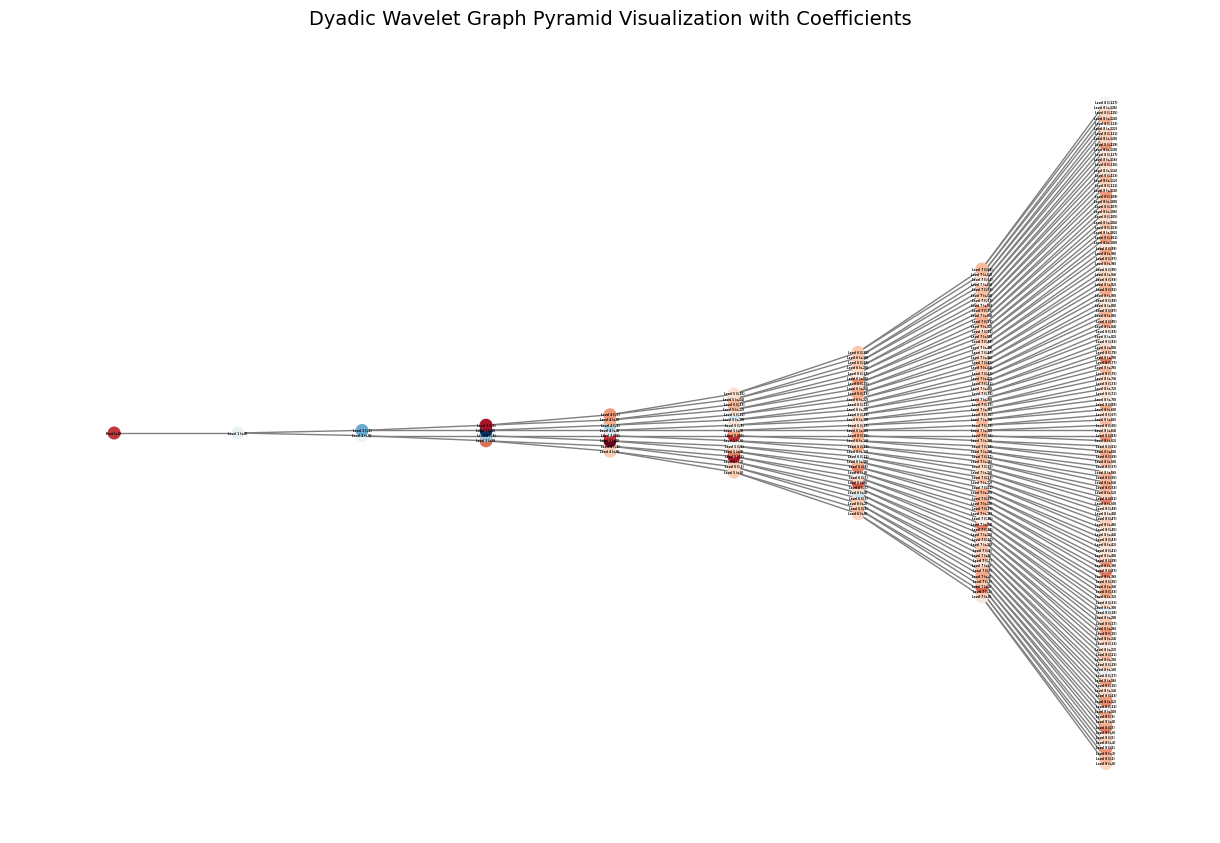

In [186]:
 
# Perform wavelet decomposition
wavelet = 'db1'
coeffs_noisy = pywt.wavedec(signal, wavelet )



# Build the dyadic wavelet graph
wavelet_graph_noisy, node_labels_noisy, node_levels_noisy, node_coefficients_noisy = build_dyadic_wavelet_graph(coeffs_noisy)

# Convert to NetworkX for visualization
g = torch_geometric.utils.to_networkx(wavelet_graph_noisy, to_undirected=True)



# Visualize the wavelet graph as a pyramid with colored nodes
draw_dyadic_wavelet_graph_pyramid(g, node_labels_noisy, node_levels_noisy, node_coefficients_noisy)


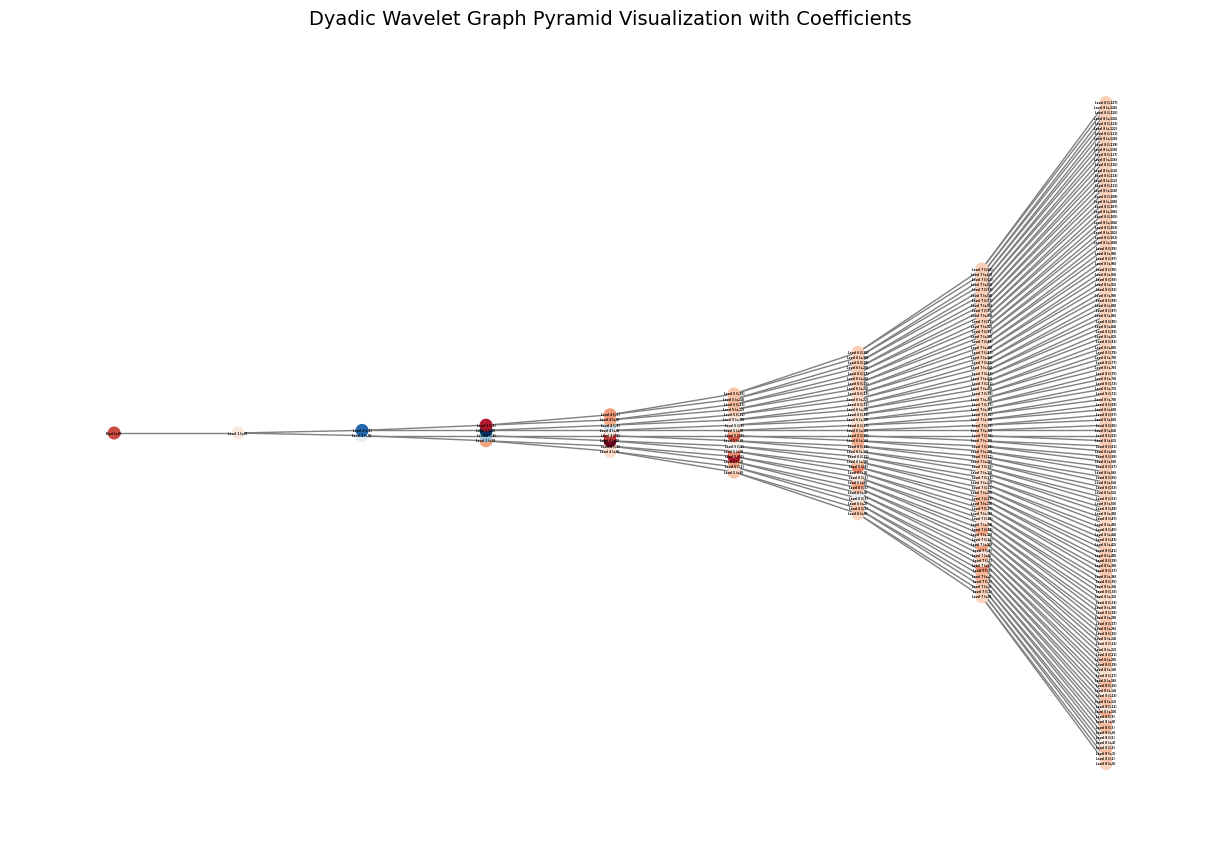

In [187]:
 
# Perform wavelet decomposition
wavelet = 'db1'
coeffs  = pywt.wavedec(doppler(x), wavelet )



# Build the dyadic wavelet graph
wavelet_graph , node_labels , node_levels , node_coefficients  = build_dyadic_wavelet_graph(coeffs )

# Convert to NetworkX for visualization
g = torch_geometric.utils.to_networkx(wavelet_graph , to_undirected=True)



# Visualize the wavelet graph as a pyramid with colored nodes
draw_dyadic_wavelet_graph_pyramid(g, node_labels , node_levels , node_coefficients )

In [188]:
np.concatenate( coeffs ).shape

(256,)

In [189]:
np.concatenate( coeffs_noisy ).shape

(256,)

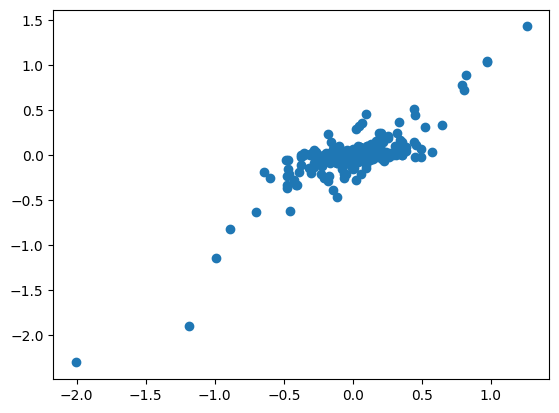

In [190]:
plt.scatter(np.concatenate( coeffs_noisy), np.concatenate( coeffs ))
 

In [191]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *

In [192]:
res= ash(np.concatenate( coeffs_noisy), np.full_like(np.concatenate( coeffs_noisy) ,0.2 ))

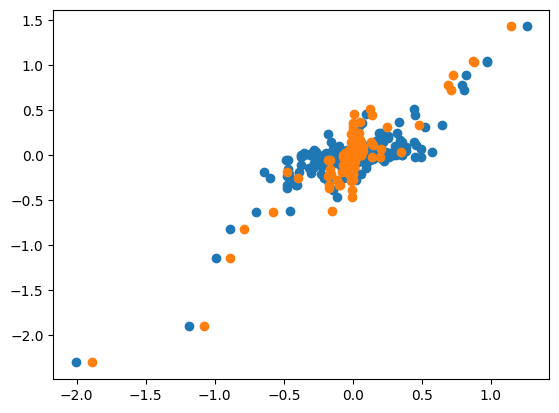

In [193]:
plt.scatter(np.concatenate( coeffs_noisy), np.concatenate( coeffs ))
plt.scatter( res.post_mean , np.concatenate( coeffs ))

In [194]:
ncoeffs= coeffs
h=0
for  s in range(len(coeffs)):
    for l in range(coeffs[s].shape[0] ):
        ncoeffs[s][l] =res.post_mean[h]
        h=h+1

In [195]:
tt= pywt.waverec(ncoeffs, wavelet)

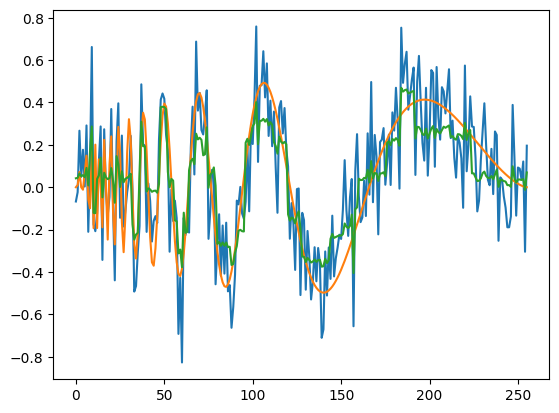

In [196]:
plt.plot(signal)
plt.plot(doppler (x))

plt.plot(tt)

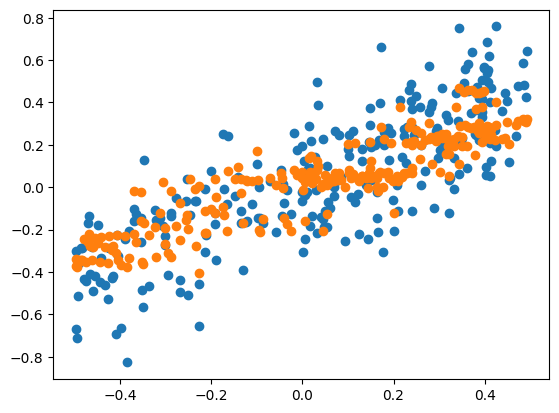

In [197]:
 
plt.scatter(doppler (x),signal)

plt.scatter(doppler (x),tt)


In [198]:
coeffs[2].shape[0] 

coeffs

[array([0.6914253]),
 array([-0.17747642]),
 array([-0.14863767, -1.07988729]),
 array([ 0.2492986 , -0.8883681 , -1.88838428,  0.87126625]),
 array([ 1.91938698e-03,  1.01903798e-03,  1.14865159e+00,  7.23763691e-01,
        -3.96922218e-01, -7.91675619e-01,  1.52651193e-02,  4.99018345e-02]),
 array([ 0.00189391, -0.00405386,  0.00215529,  0.87405538,  0.14171882,
        -0.00653376, -0.09994845,  0.70833098,  0.02347584, -0.09494298,
        -0.00838276, -0.47778318, -0.00913076,  0.01372   ,  0.01074974,
        -0.00574301]),
 array([-6.08801612e-04,  9.67244330e-03,  1.31272202e-04,  2.89864730e-03,
        -5.75992049e-01, -5.22179613e-03,  4.81716345e-01,  2.05904111e-04,
        -1.73158109e-01,  1.26412837e-01,  1.29505864e-02, -1.74294885e-01,
        -1.11596425e-01,  1.60340977e-02, -1.19890824e-02,  1.27311102e-02,
         1.72249904e-02, -4.94713293e-04, -1.04274325e-02,  5.04108793e-04,
        -4.14737126e-02, -1.76919821e-02, -6.23750642e-03,  1.59107884e-02,
      

In [206]:
def draw_predictions(g, predictions):
    plt.figure(figsize=(12, 8))
    pos = nx.multipartite_layout(g, subset_key='subset')

    # Ensure alignment between graph nodes and predictions
    node_colors = []
    for node in g.nodes():
        try:
            node_colors.append(predictions[node].item())  # Use predictions[node] if aligned
        except IndexError:
            raise ValueError(f"Prediction for node {node} is out of bounds.")

    cmap = plt.cm.RdBu_r
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))

    nx.draw(
        g, pos, with_labels=True,
        node_size=700, node_color=node_colors, cmap=cmap, font_size=8, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label="Predicted Coefficients")
    plt.title("Wavelet Graph with Predictions")
    plt.show()


In [207]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import torch_geometric
from torch_geometric.data import Data, DataLoader
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate a spiked signal (Donoho's example)
def generate_spiked_signal(n, spikes):
    """
    Generate a spiked signal of length n with specific spike locations and magnitudes.
    """
    signal = np.zeros(n)
    for loc, mag in spikes:
        signal[loc] = mag
    return signal

# Example parameters
n = 124
spikes = [(20, 5), (50, -7), (90, 10)]  # Locations and magnitudes of spikes
signal = generate_spiked_signal(n, spikes)

# Perform wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet, level=7)

 
# Build the dyadic wavelet graph
wavelet_graph, node_labels, node_levels, node_coefficients = build_dyadic_wavelet_graph(coeffs)

# Add subset information for visualization
for node, level in node_levels.items():
    g.nodes[node]['subset'] = level  # Add subset information for each node

# Define a GNN model for prediction
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Prepare data for the GNN
for i in range(len(wavelet_graph.x)):
    wavelet_graph.x[i][-1] = node_coefficients[i]  # Add coefficients as node labels

# Split data into train/test
num_nodes = wavelet_graph.x.shape[0]
train_mask = torch.rand(num_nodes) < 0.8  # 80% for training

# Train the GNN model
input_dim = wavelet_graph.x.shape[1]
hidden_dim = 32
output_dim = 1

model = GNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

wavelet_graph.train_mask = train_mask
train_data = DataLoader([wavelet_graph], batch_size=1)

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(wavelet_graph)
    loss = loss_fn(out[train_mask].squeeze(), wavelet_graph.x[train_mask, -1])
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Visualize the wavelet graph with predictions
 
# Generate predictions and visualize
data_pred = model(wavelet_graph).detach().numpy()



Epoch 1, Loss: 0.7054
Epoch 2, Loss: 0.6959
Epoch 3, Loss: 0.6880
Epoch 4, Loss: 0.6800
Epoch 5, Loss: 0.6717
Epoch 6, Loss: 0.6639
Epoch 7, Loss: 0.6557
Epoch 8, Loss: 0.6481
Epoch 9, Loss: 0.6407
Epoch 10, Loss: 0.6343
Epoch 11, Loss: 0.6297
Epoch 12, Loss: 0.6252
Epoch 13, Loss: 0.6194
Epoch 14, Loss: 0.6126
Epoch 15, Loss: 0.6032
Epoch 16, Loss: 0.5937
Epoch 17, Loss: 0.5832
Epoch 18, Loss: 0.5717
Epoch 19, Loss: 0.5602
Epoch 20, Loss: 0.5484
Epoch 21, Loss: 0.5353
Epoch 22, Loss: 0.5216
Epoch 23, Loss: 0.5082
Epoch 24, Loss: 0.4943
Epoch 25, Loss: 0.4810
Epoch 26, Loss: 0.4679
Epoch 27, Loss: 0.4558
Epoch 28, Loss: 0.4438
Epoch 29, Loss: 0.4326
Epoch 30, Loss: 0.4219
Epoch 31, Loss: 0.4129
Epoch 32, Loss: 0.4035
Epoch 33, Loss: 0.3943
Epoch 34, Loss: 0.3872
Epoch 35, Loss: 0.3814
Epoch 36, Loss: 0.3769
Epoch 37, Loss: 0.3726
Epoch 38, Loss: 0.3694
Epoch 39, Loss: 0.3676
Epoch 40, Loss: 0.3659
Epoch 41, Loss: 0.3636
Epoch 42, Loss: 0.3611
Epoch 43, Loss: 0.3587
Epoch 44, Loss: 0.35

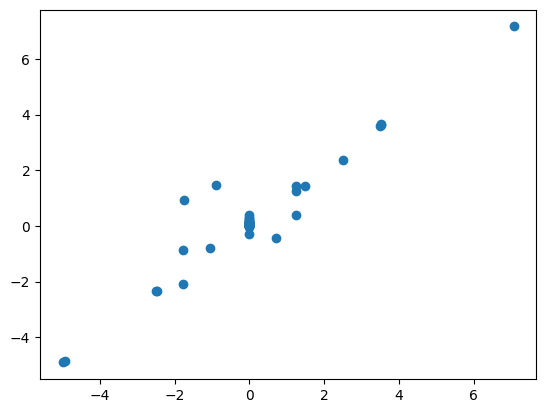

In [204]:
plt.scatter(np.concatenate(coeffs),data_pred)